<a href="https://colab.research.google.com/github/lindsay99m/Scikit/blob/main/LMoller_Scikit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit-image Tephra Data

## Hysterisis Thresholding

I am using this method to try and outline the large tephra shards to help better identify their shape and structure and remove the background noise.

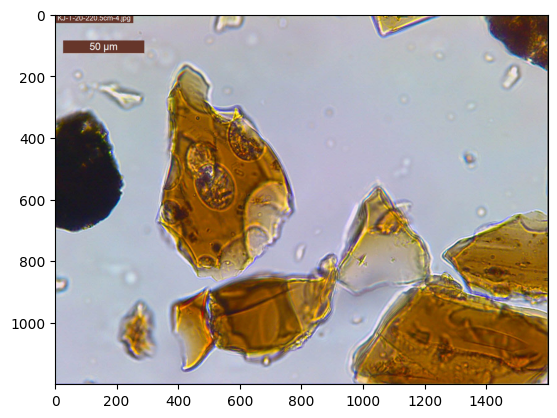

In [1]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage import data, filters
import numpy as np

url = 'https://raw.githubusercontent.com/lindsay99m/Scikit/fb95c1e682c2cd4b4f1842af62e7ad80d1f4130e/KJ-T-20-220.5cm-4.jpg'
tephra_220 = requests.get(url)
image= Image.open(BytesIO(tephra_220.content))
# Convert the image to a NumPy array
image_np = np.array(image)
plt.imshow(image_np)

Edge value range: 0.0 to 0.5773559572049164


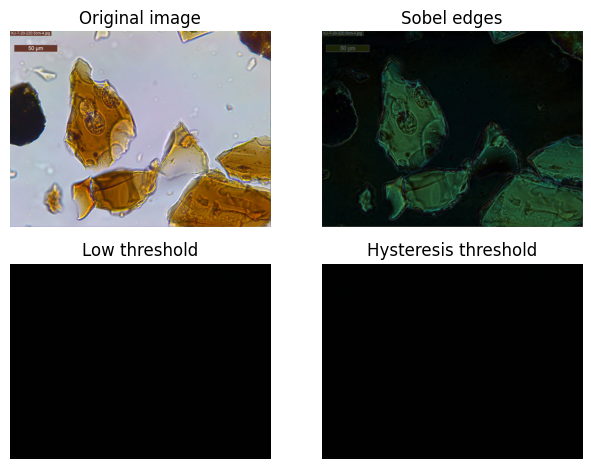

In [2]:
#perform hystersis thresholding to try and remove noise from larger tephra

from skimage import exposure, filters

fig, ax = plt.subplots(nrows=2, ncols=2)

edges = filters.sobel(image_np)
print(f"Edge value range: {edges.min()} to {edges.max()}")

low = 0.0
high = 0.57

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)


lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)


ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

While the Sobel edges helped highlight the shape and structure of the tephra while filtering out most of the background noise, the low threshold and hysteresis threshold would not produce the outlines no matter how much I tried to tweak the range or boundaries for the edges. this could be due to the "fuzzy" nature of the tephra images as it is hard to catpure the edges of the shards becuase they are somewhat seethrough and are 3D.

## Removing small objects in grayscale images with a top hat filter

I am using this method to try and remove the smaller noise in the background and smaller particles from the more obvious and larger shards.

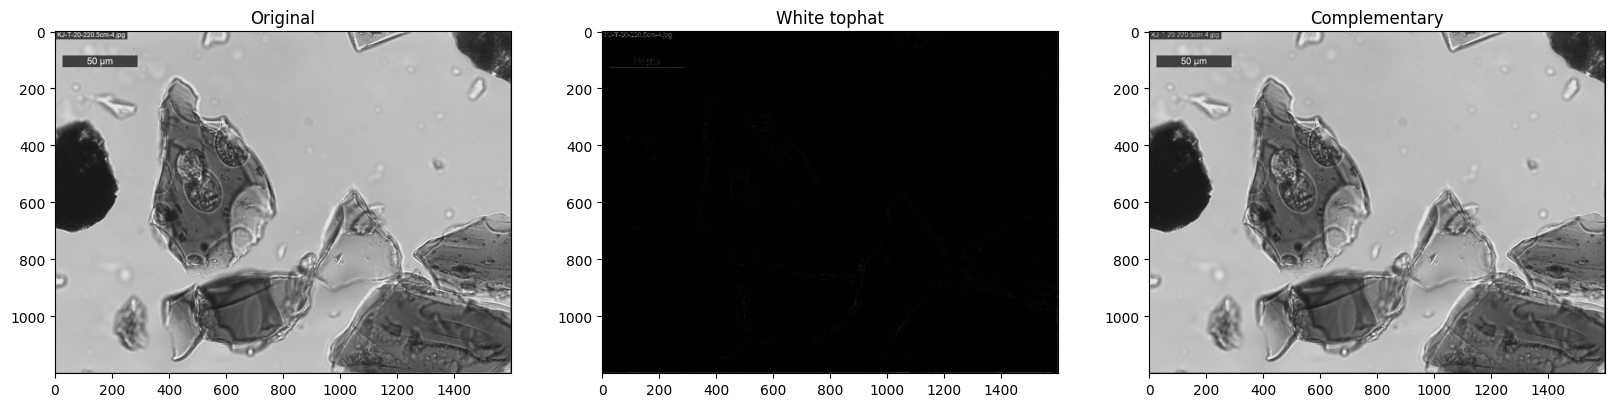

In [3]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color, morphology
from io import BytesIO
from PIL import Image

# Access the image content from the response object and open it
image = Image.open(BytesIO(tephra_220.content))

# Convert the image to grayscale
image = color.rgb2gray(np.array(image)) # Convert to NumPy array before rgb2gray

footprint = morphology.disk(1)
res = morphology.white_tophat(image, footprint)

fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
ax[0].set_title('Original')
ax[0].imshow(image, cmap='gray')
ax[1].set_title('White tophat')
ax[1].imshow(res, cmap='gray')
ax[2].set_title('Complementary')
ax[2].imshow(image - res, cmap='gray')

plt.show()

The sediment shards are too large to be filtered out from the background using this method and therefore the complementary image is notmuch different than the original image. This method seems to only work when an image is very black and white and what you are trying to filter out is extremely small.

## Filtering regional maxima

I am using this method to try and remove the more obvious mineral debris from the smaller noise in the background of smaller particles.

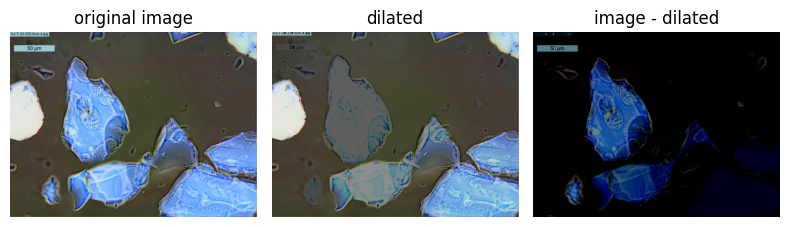

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float, util
from skimage.morphology import reconstruction
from io import BytesIO
from PIL import Image

image = Image.open(BytesIO(tephra_220.content))  # Re-open the image from response content

image = img_as_float(np.array(image))
image = util.invert(image)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True
)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

When initially running this the tephra shards were being dialated out, so by inverting the image I was able to remove the background and the noise inorder to highlight the larger tephra shards. This still removed some of the tephra on the edge.

## Thresholding



I am using this method to try and remove the more obvious mineral debris from the smaller noise in the background of smaller particles.

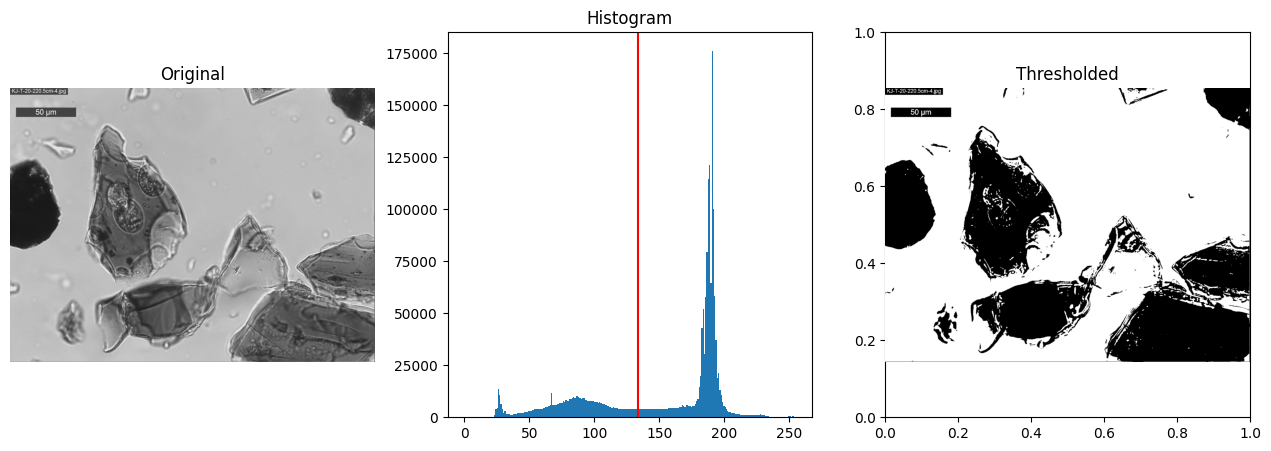

In [5]:
from skimage.filters import threshold_otsu

image = Image.open(BytesIO(tephra_220.content)) # Open the image from the response content
# Convert the image to grayscale if necessary
image = image.convert('L')
# Convert the image to a NumPy array
image = np.array(image)

thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

This version of thresholding performs much better than the hysterisis thresholding are seperating the tephra from the noise/ smaller bit.

## RGB to HSV

I used this method to try and see if the hue changes made the minerals more obvious against their background and if that could be used for preliminary data analysis and search to choose what shards to test first.

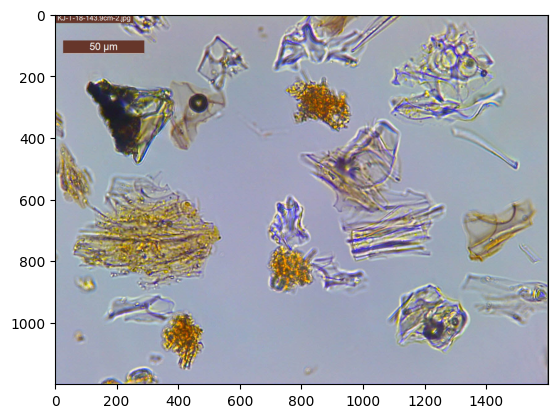

In [6]:
from skimage.color import rgb2hsv

url = 'https://raw.githubusercontent.com/lindsay99m/Scikit/a2b2357a330c77b39c97577cd2611396a97f6e2b/KJ-T-18-143.9cm-2.jpg'
tephra_144 = requests.get(url)
image= Image.open(BytesIO(tephra_144.content))
# Convert the image to a NumPy array
image_np = np.array(image)
plt.imshow(image_np)

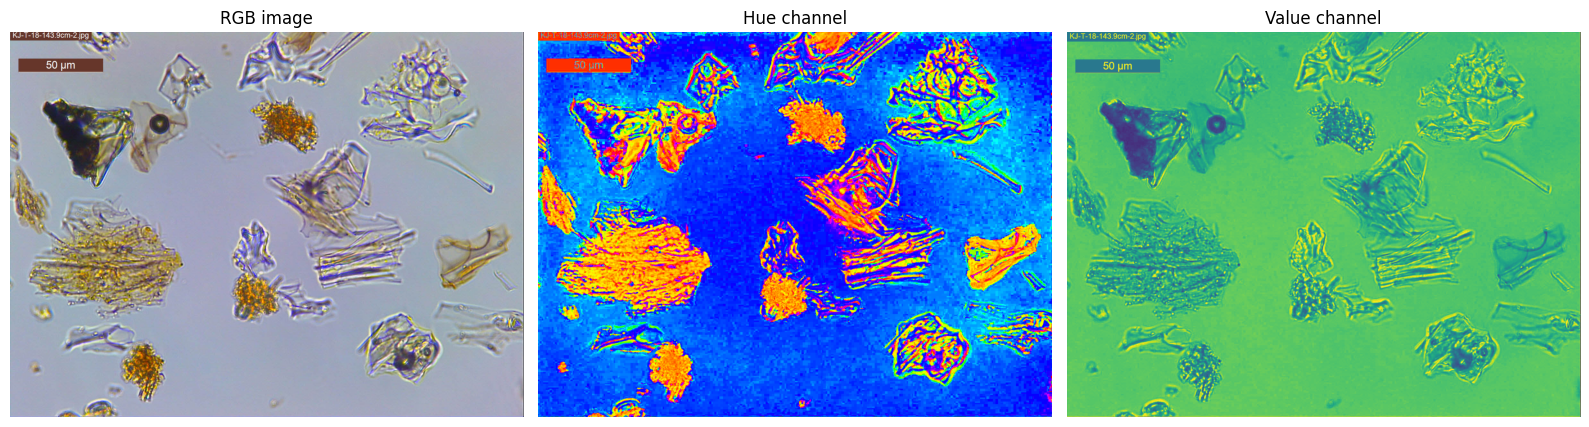

In [7]:
rgb_img = np.array(Image.open(BytesIO(tephra_144.content))) # Access image data from response content
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 5))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

The hue changing can be helpful to identify minerals and which minerals have potentially the same make up based off of their luminocity (or hue) which can be hard to do with regular RBG images. While it is not definitive to go off of it can be helpful for prelimiray analysis and data searches.

# Conclusion

I liked the thresholding method as I feel like it is very useful to be able to remove the background noise in your slide data, especially when you are looking at specific mineral shards under a microscope. Similarly I found the filtering regional maxima method useful as it was also able to remove the background noise relatively well on my slide data. I would use both these in the future but would like to spend ore time with hysteresis thresholding on different slide data to try and figure out if it is useable for tephra. I would also use RGB to HSV in sediment images as it could help to identify layers that are hard to see with the naked eye.